### Loading libraries

In [21]:
%matplotlib inline

In [53]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import norm
from IPython.display import Image # to display images 

### Approach

To summarize, the idea is to use **memory based collaborative filtering on adjacency matrix of person to predict the unknown scores**

**Solution methodology:**

* **Step1:** Use assumption 4 (*extremely unlikely that a foe of a good person to be good to fill some data*) to hard code some values. Find good peeople in foes table and fill other person by -1 (bad)
* **Step2:** Now make person/person adjacency matrix (call it relationship matrix) with binary (-1,+1) values. +1 when pair is friend and -1 when pair is foe.
* **Step3:** Calculate cosine similarity of each person pair. Here assumption 2 and 3 have been used. i.e. people with same pattern of friends and foes have higher cosine similarity (close to 1)
* **Step4**: Take difference of values in relationship adjacency matrix with pairwise cosine similarity matrix. If the difference is high, it is very likely that the data in friends table is flawed (used to find 8 most likely faults in friends table)
* **Step4:** Use pairwise cosine similarity as weight and dot product with available goodness scores to get score for missing data points. The idea is similar to memory based collaborative filtering. 
* **Step5:** Compare predictions for known persons and check accuracy 
* **Step6** Reiterate with different similarity metric, model based approach (train embeddings) etc. to increase the accuracy. (At this stage, I haven't done other experiments due to lack of time)

**Math for the approach is shown below**

<img src="matrix.jpg" alt="Drawing" style="width: 700px;"/>

### Score of further improvement and methods that can be tried but haven't been :

* The approach that has been used is called **memory based** collaborative filtering approach, which is not based on any kind of training and is primitive. We can also train low dimensional embeddings for each person by minimizing RMSE loss and use those for predictions. 
* I haven't used all assumptions in **bayes proabilistic model** to find 8 friendships in the friendships table that are most likely false. I just found **297 pairs from friends table which are duplicates in foes table also and used 4th assumption to find**. I could use other assumptions also. But current solution also gives highly likely right answer 
* Only assumption 4 has been used to hard code some data. Since the assumption says **extremely unlikely**, not **100%**, some are wrong. Maybe we can randomly assign 90% of those cases to be hard coded as bad, not 100% of those.
* **Assumption 2 and 3** are inherently used when I observed the difference in cosine similarity. Since, we have considered similar person will have similar pattern of friends and foes. 
* **Assumption 1 and 5 have not been used** since they have only talked about **quite likeliness**, not extreme unlikeliness. Maybe we can also incorporate those. By using some probability measure between 0 to 1
* We can also make features like average score of friend/foes of each person, count of friends, count of foes etc. and train a **random forest model** to predict for unknown persons. But training only on 1927 and predicting on 54k might give bad results. But this is also worth experimenting.

### Loading data

In [23]:
friends = pd.read_csv('friends.csv')
foes = pd.read_csv('foes.csv')
data = pd.read_csv('islander sample people scores.csv')

In [24]:
friends[:4]

,person1,person2
0,441e08b1_a0431c52,404021bf_898326ec
1,3f4929ef_956613b7,d6031447_a684b614
2,1f75eb7f_e1d4405b,5ccf7530_5343d32b
3,9b6edd00_179def5,e7d1222f_49ff1c63


In [25]:
friends.shape, foes.shape, data.shape

((474835, 2), (135644, 2), (1927, 2))

In [26]:
sum(data.score > 0 )/data.shape[0]

0.35755059678256357

Roughly 35% people are good

In [27]:
data[:2]

,person id,score
0,1122b7d5_ed317db7,-2
1,b0177400_be9028c7,-2


In [28]:
# range of scores

data.score.min(), data.score.max()

(-4, 5)

In [29]:
len(data['person id'].unique())

1927

## Tasks
* 8 friendships in the friendships table that are most likely false
* A classification of every individual you see (both from the friends table or the foes table) into either good,
 

### 1. 8 friendships in the friendships table that are most likely false

**We know from the given assumptions that**  
(1) It is quite unlikely for a good person to be friends with a bad person  
(2) It is extremely unlikely for a friend of a friend to be a foe  
(3) It is extremely unlikely for a friend of a foe to be a friend  
(4) It is extremely unlikely that a foe of a good person to be good  
(5) It is likely a foe of a bad person is good and a foe of a good person is bad
  
  
**Restating above assumptions for ease of analysis**  
*Let A,B represent left entry and right entries in foes/friends table* 
1. Quite unlikely event -- A: Good || B: Bad || A-B: Friends
2. Extremly unlikely event -- A-B: Friends || B-C: Friends || A-C: Foe
3. Extremly unlikely event -- A-B: Friends || B-C: Foes || A-C Friends
4. Extrememly unlikely event -- A: Good || B: Good || A-B: Foes
5. Likely -- (A: Bad || A-B: Foe || B: Good) or (A: Good || A-B: Foe || B: Bad)


And most of `foes` are correctly identified (<1% error). But relatively high percentage of friends are sloppy (<9%). So the methology of solving this question would be to trust foes table more and use above assumptions. Steps to be followed:

In [30]:
friends[:2]

,person1,person2
0,441e08b1_a0431c52,404021bf_898326ec
1,3f4929ef_956613b7,d6031447_a684b614


#### Finding unique people from both friends and foes tables and mapping scores ifd available

In [31]:
# list of all unique people in friends table.

unique_p1 = list(friends.person1.unique())
unique_p2  = list(friends.person2.unique())
unique_p1_foe = list(foes.person1.unique())
unique_p2_foe = list(foes.person2.unique())

unique_people = list(set(unique_p1 + unique_p2 + unique_p1_foe + unique_p2_foe))

In [32]:
len(unique_people)

54270

In [33]:
n = len(unique_people)

In [34]:
# dictionary with map of person id and scores. Will keep on updating nulls to add more scores
# scoers = 0 when not present

unique_people_score = {}

for i in unique_people:
    if sum(data['person id'] == i) > 0:
        unique_people_score[i] = list(data[data['person id'] == i]['score'])[0]
    else: unique_people_score[i] = 0

In [35]:
# how our dictionary looks like?

{k: unique_people_score[k] for k in list(unique_people_score)[:4]}

{'1ff6f3_b21faf52': 0,
 '4536f173_19b5efd': 0,
 'c3af2afd_6717c394': 0,
 'd5397d96_586bf4d2': 0}

#### Mapping and concatenating both friends and foes

Mapping each PersonID to numeric ID and ID to personID for each of visualization

In [36]:
id2person = {}
for i,j in enumerate(unique_people):
    id2person[i]=j

In [37]:
person2id = {}
for i,j in enumerate(unique_people):
    person2id[j]=i

Updating `Friends` and `Foes` table with only number IDs

In [38]:
friends_id = friends.copy()
friends_id.person1 = friends_id.person1.map(person2id)
friends_id.person2 = friends_id.person2.map(person2id)

In [39]:
foes_id = foes.copy()
foes_id.person1 = foes_id.person1.map(person2id)
foes_id.person2 = foes_id.person2.map(person2id)

In [40]:
# check if NAs by accident

foes_id.isna().sum()

person1    0
person2    0
dtype: int64

In [41]:
# adding relation column

friends_id['relation'] = 1
foes_id['relation'] = -1

In [42]:
friend_foe = pd.concat([friends_id, foes_id], axis=0)

In [43]:
friend_foe.person1= friend_foe.person1.astype(int)
friend_foe.person2= friend_foe.person2.astype(int)

In [44]:
friend_foe[:4]

,person1,person2,relation
0,29321,33544,1
1,8090,46289,1
2,21218,40003,1
3,37595,1115,1


### Step0: Checking and dropping duplicates in `friends` and `foes`
First check if there are relations which are both in friends and foes table. In such cases, we will be trusting foes more as foes table is more likely to be correct. These relations also most likely to be **false friends**

In [45]:
friend_foe_dups = friend_foe[friend_foe.duplicated(['person1','person2'], keep=False)].sort_values(['person1', 'person2', 'relation'])

In [46]:
sum(friend_foe_dups.relation == 1)/friend_foe_dups.shape[0] # 50% distribution of +1, -1

0.5

In [47]:
friend_foe_dups.shape[0]/2

297.0

In [48]:
friend_foe_dups.head()

,person1,person2,relation
102067,173,26001,-1
252922,173,26001,1
107388,184,35179,-1
65326,184,35179,1
38806,305,26711,-1


Dropping these duplicates from original table 

In [49]:
friend_foe_nodups = friend_foe.sort_values(['person1', 'person2', 'relation']).drop_duplicates(['person1', 'person2'])

In [50]:
friend_foe_nodups.reset_index(inplace=True, drop=True)

In [51]:
friend_foe_nodups.shape

(610182, 3)

In [52]:
friend_foe_nodups[:2]

,person1,person2,relation
0,0,36753,1
1,0,46455,1


**So, people with most likely wrong friendship status are value in list `friend_foe_dups`. I.e. 297 people**

Now we know that `It is extremely unlikely that a foe of a good person to be good`. We can find if there are any people among those 297 wrong friends who are given as good and also given as foes of a good person. They might definitely be lying

In [71]:
# score for each person based on ids

unique_people_score_ids= {person2id[i]:unique_people_score[i] for i in unique_people}

In [85]:
friends_wrong =  friend_foe_dups.drop_duplicates(['person1','person2']).reset_index().drop(['index'],axis=1)

In [99]:
friends_wrong.shape

(297, 3)

In [102]:
person1_df = pd.DataFrame(friends_wrong.person1.map(unique_people_score_ids))
person1_df.columns = ['score1']

person2_df = pd.DataFrame(friends_wrong.person2.map(unique_people_score_ids))
person2_df.columns = [ 'score2']

friends_wrong_scores = pd.concat([friends_wrong, person1_df, person2_df], axis=1)

In [103]:
friends_wrong_scores[:4]

,person1,person2,relation,score1,score2
0,173,26001,-1,0,0
1,184,35179,-1,0,0
2,305,26711,-1,0,0
3,329,33637,-1,0,0


We know that all these persons are highly likely to be foes. Now, we just need to see pairs with combination of + and - scores. They will definitely be foes

In [108]:
friends_wrong_scores[(friends_wrong_scores.score1 != 0) 
                     & (friends_wrong_scores.score2 != 0) & 
                     (np.sign(friends_wrong_scores.score1) != np.sign(friends_wrong_scores.score2)) ]

,person1,person2,relation,score1,score2
21,4702,22964,-1,2,-2
22,5091,34611,-1,4,-3
46,9158,43072,-1,-3,3
123,24844,29118,-1,-2,2
272,50709,23165,-1,3,-2


**Above 5 people are highly likely to be foes, not friends**

### **Step1** 
using assumption that `it is extremely unlikely that a foe of a good person to be good`. We find all good people in foes table, then we **hard code** rating to be bad (-1) for people whom we don't know any rating

In [31]:
foes.shape

(135644, 2)

In [32]:
# Adding both persons's scores in foes table

foes_scores = foes.merge(data, how = 'left', left_on='person1', right_on='person id')\
                  .merge(data, how = 'left', left_on='person2', right_on='person id', suffixes = (1,2))\
                  .drop(['person id1', 'person id2'], axis=1)

In [33]:
foes_scores[:2]

,person1,person2,score1,score2
0,1a78a273_69afff35,cbbb389d_6c185226,NaN,NaN
1,b49793f1_89131c25,528b6768_4cfc6dfc,NaN,NaN


Now, the logic is to look for non nulls in score1 or score2, and fill the missing one with -1. 

In [34]:
foes_scores.isna().sum()

person1         0
person2         0
score1     108436
score2     111294
dtype: int64

In [35]:
# updating score1 or score2 based on goodness of either score 1 or 2

foes_scores_up = foes_scores.copy()
foes_scores_up.loc[foes_scores_up.score1 > 0 & foes_scores_up.score2.isna(), 'score2'] = -1
foes_scores_up.loc[foes_scores_up.score2 > 0 & foes_scores_up.score1.isna(), 'score1'] = -1

In [36]:
foes_scores_up.isna().sum()

person1         0
person2         0
score1      99971
score2     100291
dtype: int64

Nulls have decreased. Now we have filled some gaps in data using the **4th assumption**. Putting it back in data

In [37]:
foes_scores_up[:2]

,person1,person2,score1,score2
0,1a78a273_69afff35,cbbb389d_6c185226,NaN,NaN
1,b49793f1_89131c25,528b6768_4cfc6dfc,NaN,NaN


Putting into common dictionary

In [38]:
person1_score_dict = {x[0]:x[1] for x in foes_scores_up.loc[:,['person1', 'score1']].drop_duplicates().values.tolist()}
person2_score_dict = {x[0]:x[1] for x in foes_scores_up.loc[:,['person2', 'score2']].drop_duplicates().values.tolist()}

In [39]:
person_score_dict_update = person1_score_dict.copy()
person_score_dict_update.update(person2_score_dict)

In [40]:
{k: person_score_dict_update[k] for k in list(person_score_dict_update)[:4]}

{'1a78a273_69afff35': -1.0,
 '653464a_6d49face': nan,
 'b49793f1_89131c25': -1.0,
 'dae7f2ef_a0eb0f08': nan}

In [41]:
# updating unique_people_score dictionary with manually predicted scores

keys = list(person_score_dict_update.keys())

for i in unique_people:
    # only update if initial value is 0 (missing)
    if unique_people_score[i] == 0:
        if [i in keys][0]:  # only update if key is present in preson_score dict
            # only update if some value is present
            if ~np.isnan(person_score_dict_update[i]):
                unique_people_score[i] = person_score_dict_update[i]

In [42]:
sum([x != 0 for x in list(unique_people_score.values())])

6179

**So, now we have filled 6179 values with some goodness score, using given assumption. Now we do matrix factorization**

### Step2: Person-Person matrix of friend or foe

Adding more rows with value of 1 when both names are same. 
**Assumption: I am friend with myself**

In [43]:
friend_foe_nodups[:2]

,person1,person2,relation
0,0,35256,1
1,0,40938,1


In [44]:
unique_people_ids = [person2id[i] for i in unique_people]

In [45]:
myself_df = pd.DataFrame(np.concatenate([np.array(unique_people_ids).reshape(len(unique_people_ids),1),
                             np.array(unique_people_ids).reshape(len(unique_people_ids),1)], axis=1))

In [46]:
myself_df.columns = ['person1', 'person2']

In [47]:
myself_df['relation'] = 1

In [48]:
myself_df[:2]

,person1,person2,relation
0,0,0,1
1,1,1,1


Putting person1 and 2 in indexes are easier conversion to sparse matrix

In [49]:
friend_foe_nodups = pd.concat([friend_foe_nodups, myself_df], axis=0)

In [50]:
friend_foe_idx = friend_foe_nodups.set_index(['person1', 'person2'])

In [51]:
friend_foe_idx[:3]

relation
person1 person2          
0       35256           1
        40938           1
        48154           1

#### Constructing sparse matrix

Matrix of each person with each other person 

In [52]:
# relation_pivot = pd.pivot_table(friend_foe, values='relation',index='person1',columns='person2')

In [53]:
#np.where(friend_foe_idx.index.duplicated())

In [54]:
friend_foe_nodups.as_matrix()

array([[    0, 35256,     1],
       [    0, 40938,     1],
       [    0, 48154,     1],
       ...,
       [54267, 54267,     1],
       [54268, 54268,     1],
       [54269, 54269,     1]])

In [55]:
len(list(set(list(friend_foe_nodups.person2.unique()))))

54270

In [56]:
len(list(set(list(friend_foe_nodups.person1.unique()))))

54270

In [57]:
#tmp=friend_foe_idx.unstack()

In [58]:
# tmp.shape

Filling 1 for one on one relation, otherwise sparse matrix will remove some rows which will cause issues in indexing later. 

In [59]:
friend_foe_nodups.shape

(664452, 3)

In [60]:
# sparse matrix of unique people in row, column and binary relation in values of matrix

sparse_mat = sps.coo_matrix((friend_foe_idx.relation, (friend_foe_idx.index.labels[0],
                                            friend_foe_idx.index.labels[1])))

In [61]:
sparse_mat

<54270x54270 sparse matrix of type '<class 'numpy.int64'>'
	with 664452 stored elements in COOrdinate format>

In [62]:
sparse_mat.todense().sum()

393164

In [63]:
friend_foe_nodups.relation.sum()

393164

Ok. So the sum is matching. So sparse matrix would be right

In [64]:
sparse_mat_den = sparse_mat.todense()
print(sparse_mat_den)

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


In [65]:
# sparse_mat.toarray().shape

In [66]:
sparse_mat.row

array([    0,     0,     0, ..., 54267, 54268, 54269], dtype=int32)

In [67]:
len(sparse_mat.col)

664452

In [68]:
sparse_mat.data

array([1, 1, 1, ..., 1, 1, 1])

In [69]:
sparse_mat_den[21962,118]

0

In [70]:
# how the data looks like 

friend_foe_idx[friend_foe_idx.index.get_loc(21962)]

relation
person1 person2          
21962   1781            1
        3573            1
        5026            1
        8115            1
        17955           1
        23846           1
        24291           1
        25355           1
        33797          -1
        36463           1
        36770           1
        40288           1
        41628           1
        45635          -1
        50990           1
        52504          -1
        53563           1
        21962           1

### Step3: Cosine similarity of each element

The idea is to compute **cosine similarity** of each person's vector based on his/her relationship with all other people. The intuition is that we can predict the unknown ratings based on weighted cosine similarity of pairwise relations 

In [71]:
from sklearn.metrics.pairwise import cosine_similarity

In [72]:
similarities = cosine_similarity(sparse_mat)
print('pairwise dense output:\n {}\n'.format(similarities))

#also can output sparse matrices
similarities_sparse = cosine_similarity(sparse_mat,dense_output=False)
print('pairwise sparse output:\n {}\n'.format(similarities_sparse))

pairwise dense output:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]

pairwise sparse output:
   (0, 48154)	0.040291148201269014
  (0, 45792)	0.11180339887498948
  (0, 41257)	-0.10660035817780521
  (0, 40976)	0.11785113019775793
  (0, 40196)	0.2886751345948129
  (0, 33050)	0.11785113019775793
  (0, 31803)	0.05590169943749474
  (0, 29709)	0.35355339059327373
  (0, 27464)	-0.10660035817780521
  (0, 23175)	0.10660035817780521
  (0, 16388)	0.10660035817780521
  (0, 15760)	0.17677669529663687
  (0, 15718)	0.07808688094430304
  (0, 13896)	0.125
  (0, 12859)	0.11470786693528087
  (0, 11769)	0.07071067811865475
  (0, 10393)	0.11470786693528087
  (0, 8510)	0.12126781251816648
  (0, 8250)	-0.019433051858411793
  (0, 6920)	-0.08006407690254357
  (0, 6184)	0.06622661785325219
  (0, 5349)	0.2886751345948129
  (0, 4901)	0.125
  (0, 3935)	0.09622504486493763
  (0, 3564)	-0.07808688094430304


Predicting for the data that is not available

In [73]:
similarities_sparse.shape # shape of matrix

(54270, 54270)

In [74]:
similarities_sparse[1,6] # sample check

0.0

### Step4: Difference in cosine similarity matrix and relationship matrix
Here the intuition is that person with similar friends and similar foes will have high cosine similarity score. This logic can be used to find the difference in cosine score with relationship matrix. High difference would mean some problem with friendship data

Matrix of interest = `similarities_sparse, sparse_mat`

In [75]:
difference_matrix = sparse_mat - similarities_sparse

In [81]:
# taken from https://stackoverflow.com/questions/22961541/python-matplotlib-plot-sparse-matrix-pattern/34255731

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.set_facecolor('xkcd:salmon')
    ax.set_facecolor((1.0, 0.47, 0.42))
                     
    ax.plot(m.col, m.row, 's', color='black', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

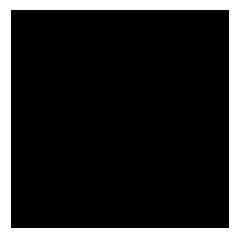

In [82]:
plot_coo_matrix(difference_matrix)

**Ok the heatmap plot didn't help. I was supposed to see black dots over salmon background wherever the difference is highest. But is made all black**

Find ones with top 8 difference and those might be 8 most likely wrongs in friendship table

In [190]:
difference_matrix_dense = difference_matrix.todense()

In [192]:
difference_matrix_array = difference_matrix.toarray()

In [ ]:
difference_matrix_array.argsort()[-8:][::-1]

This will give the pairs which are most likely false. The idea should be to filter out foes from those pairs to find only friends and also check if those are among 297 friend pair which were duplicates 

### Step5: Prediction for all people
Using weighted cosine weights of known ratings

In [79]:
# dictionary with indexes of names

unique_people_score_ids= {person2id[i]:unique_people_score[i] for i in unique_people}

In [94]:
len(unique_people_score_ids)

54270

In [98]:
{i: unique_people_score_ids[i] for i in list(unique_people_score_ids)[:7]}

{0: -1.0, 1: 0, 2: 0, 3: 0, 4: -1.0, 5: 0, 6: 0}

In [105]:
score_vector = np.array([i[1] for i in list(unique_people_score_ids.items())])

In [106]:
score_vector[:4]

array([-1.,  0.,  0.,  0.])

**Dot product of each row with vector of ratings will give prediction for each row (person id). Something like weighted avg.**

In [127]:
list(similarities_sparse.getrow(i).dot(score_vector)\
          /(norm(similarities_sparse.getrow(1))*np.linalg.norm(score_vector)))[0]

-4.958024793029746

In [128]:
# predictions

predicted_scores = []

for i in range(len(unique_people_score_ids)):
    predicted_scores.append(list(similarities_sparse.getrow(i).dot(score_vector)\
          /(norm(similarities_sparse.getrow(1))*np.linalg.norm(score_vector)))[0])

In [129]:
predicted_scores[:4]

[-4.958024793029746, 0.0, -0.02176975266724198, 0.004957207302759427]

In [157]:
predicted_scores = [int(i) for i in predicted_scores]

In [158]:
person_ids = [i[1] for i in list(id2person.items())]

**A dataframe of predictions**

In [159]:
pred_df = pd.DataFrame(np.concatenate([np.array(person_ids).reshape(-1,1) , np.array(predicted_scores).reshape(-1,1)], axis=1))

In [160]:
pred_df.columns = ['person_ids', 'predictions']

In [161]:
pred_df[:3]

,person_ids,predictions
0,49ee2a94_1d8f2738,-4
1,936a885a_4b21fcb3,0
2,91dbfeb5_ef2e8935,0


**Now, just applying logic that if predictions >= 0, then person is good otherwise person is bad**

In [172]:
pred_df['goodness'] = np.where(pred_df['predictions'].astype(int)>=0, 'good', 'bad')

In [173]:
pred_df[:3]

,person_ids,predictions,goodness
0,49ee2a94_1d8f2738,-4,bad
1,936a885a_4b21fcb3,0,good
2,91dbfeb5_ef2e8935,0,good


In [167]:
data[:2]

,person id,score
0,1122b7d5_ed317db7,-2
1,b0177400_be9028c7,-2


In [165]:
data.shape

(1927, 2)

In [174]:
data['goodness_original'] = np.where(data.score>=0, 'good', 'bad')

Appending original good/bad from given 1927 rows and checking results 

In [176]:
pred_df2 = pred_df.merge(data, how='left', left_on='person_ids', right_on='person id'  )[['person_ids',
                                                                               'goodness',
                                                                               'goodness_original']]

In [181]:
sum(pred_df2.goodness == pred_df2.goodness_original)/data.shape[0]

0.3632589517384536

Ok. So, the results are not much accurate at this stage. Below are a few points for score of improvement of the model. But because of time constaints, I am unable to do those now. 

### End